# Implementing QAOA to solve Weighted Maxcut Problem Using Tensor Networks

**Note :** This QAOA circuit was implemented for QOSF screening task. Due to my interest, I implemented the same problem statement using TNs. I have added a very short introduction to TNs here. Pennylane implementation can be found in the repositiory. Results can be compared. Referaces for both TN and QAOA can be found in the end of the notebook. 

## What are Tensors?
The older definitions describe tensors as **Multi-indeced objects that follow some transformation rule**. This definition defines tensors via transformation rules. Different aspects of tensors (if defined) such as structure of eigenvalues and eigenvectors, structure of singular values and vectors, rank, norm, determinant, structure of linear system remain invarient under different transformation rules. A common mistake in understanding this definition is emphasizing more on the *Multi-indexed object* part thant the *tranformation rule* part. Multi-indexed objects *represent* tensors and *transformation rules* define them. 

The problem with this definition is that it talks about transformation rules of the tensors without actually describing what tensors are. That is why it is the trickiest to be discussed. This issue is resolved by modern definitons in the light of linear algebra. Tensors can be interpreted as **vectors** and **Multilinear Maps**

### Vectors as Tensors :
Consider a d-dimensional Hilbert space $C^d$ denoted by $H$ with basis $|0\rangle$, $|1\rangle$........$|d-1\rangle$. Now consider $n$ copies of this Hilbert space, $C^{d^{n}}$ denoted by $H^{\otimes n}$. A vector belonging to this space can be represnted as, 

$\large T = \sum_{l_{1}l_{2}..l_{n}} T_{l_{1}l_{2}..l_{n}}|l_{1}l_{2}..l_{n}\rangle$.

Where $|l_{i}\rangle \in$ the basis of ith copy of Hilbert space $H$. They are also reffared to as indices. This is vector interpretation of a tensor $T \in$ $H^{\otimes n}$. For $d = 2$ the equation above can represent a quantum **state vector** of $n$ qubits.

### Multilinear maps as Tensors :
A map taking multiple inputs and acting linealry on each variable when others are fixed is called a Multilinear Map.Assume two vector spaces $H^{\otimes n_{1}}$ and $H^{\otimes n_{2}}$. Let $T$ be a multilinear map from $H^{\otimes n_{1}}$ to $H^{\otimes n_{2}}$. $T$ can be represented as 

$ \Large T(|a_{1}a_{2}..a_{n_{1}}\rangle) = \sum_{a_{1}a_{2}..a_{n_{1}}b_{1}b_{2}..b_{n_{2}}} T_{a_{1}a_{2}..a_{n_{1}}b_{1}b_{2}..b_{n_{2}}} |b_{1}b_{2}..b_{n_{2}}\rangle$. 

Where $|a_{i}\rangle \in$ the basis of $H^{\otimes n_{1}}$ and $|b_{i}\rangle \in$ the basis of $H^{\otimes n_{2}}$. This map is an interpretation of a tensor with rank $n_1 + n_2$. Depending on the rank number of such maps are possible. This set of multilinear maps also forms a vector space. This is linear map interpretation of tensors. **Quantum gates** acting on qubits can be viewed as multilinear maps. 

As mentioned above these tensors are represented by **Multi-indexed objects** with dimension depending on their rank. Rank-0 tensors have zero indices and represent **scalers**. Rank-1 tensors represent **vectors** and rank-2 tensors represent **matrices**. 

## Tensor Network
Interconnected tensors form Tensor Network. We have seen above qubits and quantum gates both can be seen as tensors. Thus a tensor network can be interpreted as a quantum circuit. We represnt quantum states as Tensor Network. These connections capture **entanglement** properties of the system. 

Consider a quantum state $|\psi\rangle$ with $N$ qubits which is a tensor with $N$ indices. $|\psi\rangle =  \psi_{n_1n_2..n_N}|n_1n_2..n_N\rangle$. As N will increase number of coefficients will increase exponetially. It will be a tedious task to store such a huge array of coefficients. The solution is to represent this big tensor as interconnected tensors with smaller rank. So the state $|\psi\rangle$ can be decomposed into tensor networks such as **Matrix Product State (MPS)**, **Projected Entangled Pair States (PEPS)**, **Multi-scale entanglement renormalization ansatz (MERA)** or arbitary tensor networks. 

### Operations on Tensors

**Tensor product :** Two tensors with rank $p$ and $q$ and are not connected to each other through any index, undergoing tansor product produce a new tensor with rank $p+q$. Assume two tensors with ranks $p$ and $q$ respectivey denoted by $ A = A_{a_{1}a_{1}..a_{p}}|a_1a_2..a_p\rangle$ and $B = B_{b_{1}b_{1}..b_{q}}|b_1b_2..b_q\rangle$. Then $\large A \otimes B =\sum A_{a_{1}a_{1}..a_{p}} \cdot B_{b_{1}b_{1}..b_{q}}|a_{1}a_{1}..a_{p}b_{1}b_{1}..b_{q}\rangle$.  

**Tensor Contraction :** Contraction is the sum over all the possible values of indices over which two tensors are connected. There is close correspondance between scalar product and tensor contraction over shared indices. 

## Problem Statement
Implement QAOA to solve MAXCUT on a weighted graph without using inbuilt QAOA functions.

### Importing required libraries

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
import seaborn as sns

### Generating weighted graph

Last element of each tuple in the list 'graph' is the weight of the edge between nodes denoted by first two elements of the tuple

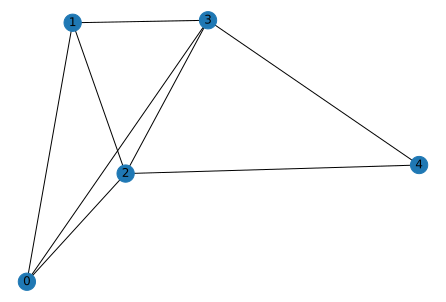

In [2]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

### Generating Ansatz

Initializing the qubits in uniform superposition of all possible states.  Numberof qubits is equal to the Number of nodes of the graph. 

$|+_{n}\rangle$ = $(1/2^{n/2}) \sum_{z \in {(0,1)}^n} |z\rangle$ 

In [3]:
def initialization(circ):
    for i in range(circ.N):
        circ.apply_gate('H',i,gate_round=0)
    return circ

The classical cost function we are trying to optimize is $C$ = $\sum_{i,j}(z_i * z_j - I)$. In Quantum cost hamiltonian each of these $z_i$ is promoted to $pauliZ$ operator as $pauliZ$ oparators has eigen values $+1$ and $-1$ for $|0>$ and $|1>$ states respectively. The Cost Hamiltonian obtained is $H$ = $\sum_{i,j}(Z_{i} \otimes Z_j - I)$. Unitary corresponding to the Cost Hamiltonian in the layer $l$, acting on qubits $i$ and $j$ (edge $ij$) is $U_{C_{l}}$ = $\Pi_{ij}  e^{i\gamma_{l}(z_i * z_j - I)}$

In [4]:
def cost_unitary(circ,gamma,gate_round):
    for edge in graph:
        circ.apply_gate('RZZ', edge[2]*gamma,edge[0], edge[1], gate_round=gate_round)
    return circ

Matrix Hamiltonian should not commute with the Cost Hamiltonian. Unitary corresponding to the Mixture Hamiltonian in layer $l$ is acting on qubit $i$ is $U_{B_{l}}$ = $\Pi_{ij}  e^{i\beta_{l}(X_i)}$ 

In [5]:
def mixture_unitary(circ,alpha,gate_round):
    for i in range(circ.N):
        circ.apply_gate('RX', alpha, i, gate_round=gate_round)
    return circ

Defining ansatz function which creates circuit for one layer. One layer contains two blocks of $U_C$ and $U_B$.$|Ansatz>$ = $|U_{C_{l}}U_{B_{l}}U_{C_{l-1}}U_{B_{l-1}}.....U_{C_{1}}U_{B_{1}}>$

In [6]:
def anasatz(gammas, alphas, n_layers,n_nodes):
    N = n_nodes
    circ = qtn.Circuit(N)
    circ = initialization(circ)
    for i in range(n_layers):
        circ = cost_unitary(circ,gammas[i],gate_round=i)
        circ = mixture_unitary(circ,alphas[i],gate_round=i)
    return circ

In [7]:
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

Initializing random parameters and creating a circuit depth of 4.  

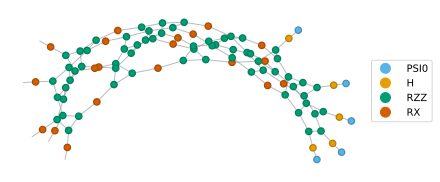

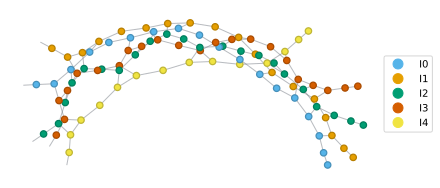

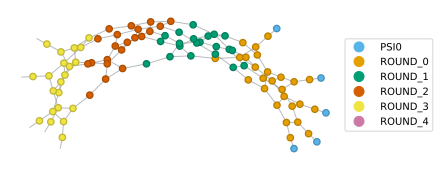

In [8]:
p=4
n=n_nodes
init_params = np.array([float(random.randint(-314, 314))/float(10000) for i in range(0, 2*p)])
gammas, alphas = create_params(init_params)
circ = anasatz(gammas, alphas, p,n)
circ.psi.draw(color=['PSI0', 'H', 'RZZ', 'RX'])
circ.psi.draw(color=[f'I{i}' for i in range(5)])
circ.psi.draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(5)])

### Defining Reusable Hyper optimizer to find contarction path
Contraction Path is a series of pairwise tensor contractions that turn the tensor network into a single tensor. The memory required for the intermediate tensors can be checked in advance at this stage. The main computational bottleneck is the actual contraction of the main tensor network objects, post simplification. The cost of this step can be incredibly sensitive to the contraction path.

In [10]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
    
)

We have use cotengra package here. Path found by a Reusable optimizer is cached and the task of finding contraction path is not performed again for the same network. Instead the cached information is used.

### Performing Rehearsals
To fulfill our purpose of solving the MAXCUT problem We are calculating sum of local expectation values of ZZ operator. In Quimb we can perform rehearsals before performing the actual contraction to calculate the local expectations. At this stage contraction path is generated but contraction is not performed. From rehearsals we also get contraction cost which is defined as log10 of the total number of scalar operations during the contraction sequence and contraction width. This is defined as log2 of the maximum tensor size produced during the contraction sequence.

In [11]:
ZZ = qu.pauli('Z') & qu.pauli('Z')
local_exp_rehs = [circ.local_expectation_rehearse(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]

We plot contraction width and contraction cost for contraction performed to calculate each local expectation value.

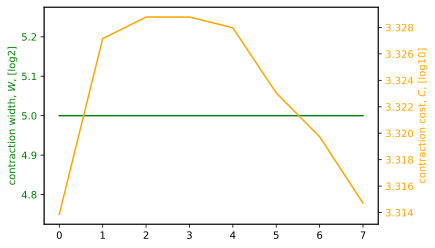

In [12]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green')
ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange')
ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

For small networks contraction is width is generally 5 which we can see in the graph above.

### Visualizing Contraction Tree

Contraction trees are **binary rooted tree embeddings** of the tensor network. In a contraction tree, tensors are assigned to the leaves I am plotting here contraction tree for one of the contractions performed. 

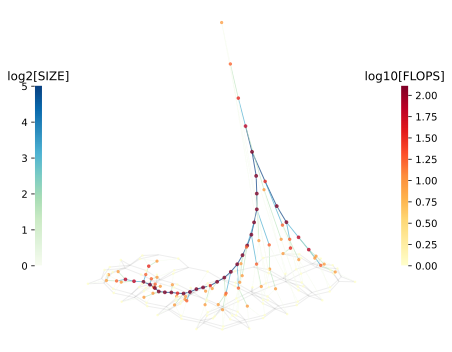

Total number of flops:4120


In [13]:
rehs=local_exp_rehs[0]
tree = ctg.ContractionTree.from_info(rehs['info'])
tree.plot_tent()
print("Total number of flops:{}".format(tree.total_flops()))

Here the, grey network at the bottom is the TN to be contracted, and the tree above it depicts the series of pairwise contractions and their individual cost needed to find the output answer (the node at the top).We can see that the contraction found is **balanced**, with **small tensors not being steadily absorbed into one big tensor**. If the tree is imbalanced it can be reconfigured to reduce number of flops

One more plot function allows one to investigate the actual numbers involved:

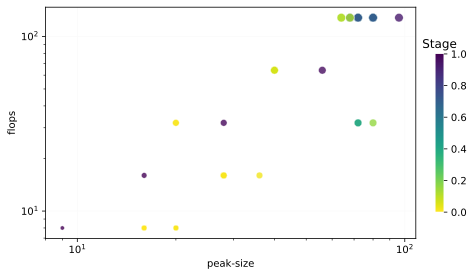

In [14]:
tree.plot_contractions()

Here, 'peak-size' is the memory required for both inputs and the output of each contraction. We can see that at higher stages peak-size steadily decreases. 

### Defining Cost Function

In [15]:
def cost_function(params):
    gammas, alphas = create_params(params)
    circ = anasatz(gammas, alphas, p,n)
    cost = 0
    ZZ = qu.pauli('Z') & qu.pauli('Z')
    expns = [circ.local_expectation(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    cost = 0.5*(sum(expns).real)
    return cost

### Performing optimization

In [16]:
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective
bounds = ([(-np.pi, np.pi)] * p + [(-np.pi, np.pi)] * p)
bopt = Optimizer(bounds)

In [17]:
import tqdm
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, cost_function(x))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [48:52<00:00, 29.33s/it]


Optimized cost is :-5.617510933999673


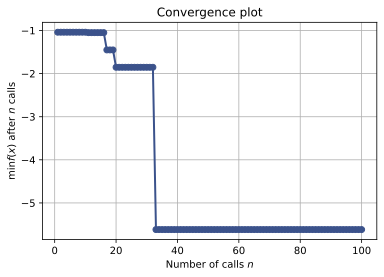

In [18]:
plot_convergence(res);
print("Optimized cost is :{}".format(res.fun))

In [19]:
def create_bitstrings(opt_params):
    opt_gammas, opt_alphas = create_params(opt_params)
    opt_circ = anasatz(opt_gammas, opt_alphas, p,n)
    bitstrings = Counter(opt_circ.sample(1000))
    return bitstrings, opt_circ

### Plotting Bitstrings for optimized circuit

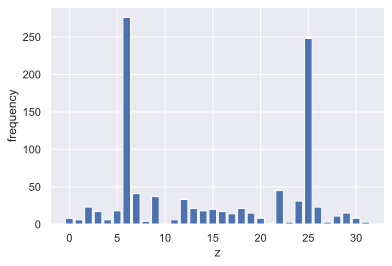

Z with maximum frequency is  :6


In [20]:
bitstrings, opt_circ = create_bitstrings(res.x)
x=[]
y=[]
for key in bitstrings.keys():
    num = 0
    
    for i in range(len(key)):
        num = num + pow(2,i)*int(key[len(key)-1-i])
    x.append(num)
    y.append(bitstrings[key])
    if bitstrings[key] == max(y):
        maximum = num
sns.set()
plt.bar(x,y,color='b')
plt.xlabel("z")
plt.ylabel("frequency")
plt.show()
print("Z with maximum frequency is  :{}".format(maximum))

**Referances :** 

QAOA 
- https://lucaman99.github.io/new_blog/2020/mar16.html
     
- https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
     
- https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html
     
TN   
- https://arxiv.org/pdf/1306.2164.pdf

- https://arxiv.org/abs/1912.10049

- http://tensornetwork.org/

- https://quimb.readthedocs.io/en/latest/examples/ex_tn_qaoa_energy_bayesopt.html

- https://github.com/jcmgray/cotengra